# MMMI Oversight Script


**TODO**: Encapsulate broker interactions

Linked problems:
**TODO**: Quarterly share updates after consumption etc.
**TODO**: Debug wealth update: they will need to sell shares sometimes?
-- problem because they are financing consumption with shares which then need to be sold, but the price is moving.

**TODO**: track and display agent histories of consumption and earnings as well as dividend payouts.

**TODO**: Consolidate initial setup to use same scripts as in interim. I.e., by having all agents 'attentive' to start.

**TODO**: Test for expected behavior with maximum attention rating (1)

**TODO**: `requirements.txt`

**TODO**: Begin automated tests

**TODO**: How do deal with varying 'AdjustPrbs' in quarterly and daily solution steps.

**TODO**: What are the macro population statistics, given our concept of macro agents including institutional investors, etc.

**TODO**: Fix steady state computation

**TODO**: Reduce NL logging/warning in the notebook.

In [1]:
import HARK.ConsumptionSaving.ConsPortfolioModel as cpm
from HARK.Calibration.Income.IncomeTools import (
     sabelhaus_song_var_profile,
)
import hark_portfolio_agents as hpa

import logging
from math import exp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

## Portfolio Consumption Model

Variable | Equation | Operation | Stage | Utility
-- | -- | -- | -- | --
\Risky | ~Dist | Shock | c | --
\TranShk | ~Dist | Shock | c | --
\PermShk | ~Dist | Shock | c | --
\Rport | \Rport = \PortShare * \Risky + (1 - \PortShare) * R | Update | c | --
b | b_{t} = a_{t-1} \RPort | Update | c | --
p | p_{t}=p_{t-1}\PermShk_{t} | Update | c | --
y | y_{t} = p_{t}\TranShk_{t} | Update | c | --
m | m_{t} = b_{t} + y_{t} | Update | c | --
c | c | Control | c | U(c)
a | a_{t} = m_{t} - c_{t} | Update | portshare | --
\PortShare | \PortShare | Control | portshare | 0


## Initialize the Simulation

### Initialize market information

Some initial values for the simulation.

$RAP_0$ is the starting risky asset price. This is adjust after every trading day.

HARK uses numerical values for wealth. This variable converts "HARK money" to dollars.

In [2]:
dollars_per_hark_money_unit = 1500

Expected rate of return and standard deviation of the market price process will be updated over time.

These are the starting values, derived from the S&P 500.

$\bar{r}_0 = 0.000628$

$sr_0 = 0.011988$

In [3]:
sp500_ror = 0.000628
sp500_std = 0.011988

market_rate_of_return = sp500_ror
market_standard_deviation = sp500_std

Quarterly dividend rate and standard deviation.

In [4]:
dividend_ror = 0.03
dividend_std = 0.01

Calendar variables. Will ultimately set to be realistic; for now set low for testing.

In [5]:
# Now set in Financial Model
days_per_quarter = 60 # Number of days in a quarter / An empirical value based on trading calendars.

# Simulation parameters
quarters_per_simulation = 6 # Number of quarters to run total

# Number of market runs to do per quarter
# Valid values: 1, 2, 3, 4, 5, 6, 10, 12, 15, 20, 30, 60...
runs_per_quarter = 2 

# For John's prefered condition: days per quarter = runs per quarter
# Best if an integer.
days_per_run = days_per_quarter / runs_per_quarter

An attention rate: the chance on any run that an agent will pay attention to the market and trade.

Later, this can be a more realistic function of agent circumstances.

In [6]:
attention_rate = 1 / runs_per_quarter ## upping this to make more agents engaged in trade

A times we will need to combine the quarterly rates from the price process (capital gains) and the dividends.


### Data stores

For prices, rates or return, and standard deviations over time.

In [7]:
buy_sell_list = []

owned_shares_list = []
total_asset_levels_list = []

### Calculating risky expectations



In [8]:
import math

class FinanceModel():
    """
    A class representing the financial system in the simulation.

    Contains parameter values for:
      - the capital gains expectations function
      - the dividend
      - the risky asset expectations
      
    Contains data structures for tracking ROR and STD over time.
    """
    # Empirical data
    sp500_ror = 0.000628
    sp500_std = 0.011988
    
    # Simulation parameter
    days_per_quarter = 60
    
    # Expectation calculation parameters    
    p1 = 0.1
    delta_t1 = 30

    a = - math.log(p1) / delta_t1

    p2 = 0.1
    delta_t2 = 60

    b = math.log(p2) / delta_t2
    
    # Quarterly dividend rate and standard deviation.
    dividend_ror = 0.03
    dividend_std = 0.01
    
    # Data structures. These will change over time.
    starting_price = 100
    prices = [starting_price]
    ror_list = []

    expected_ror_list = []
    expected_std_list = []
    
    def add_ror(self, ror):
        self.ror_list.append(ror)
        asset_price = self.prices[-1] * (1 + ror)
        self.prices.append(asset_price)
        return asset_price
    
    def __init__(self, dividend_ror = None, dividend_std = None):
        
        if dividend_ror:
            self.dividend_ror = divedend_ror
            
        if dividend_std:
            self.dividend_std = dividend_std
        pass
    
    def calculate_risky_expectations(self):
        """
        Compute the quarterly expectations for the risky asset based on historical return rates.
    
        In this implementation there are a number of references to:
          - paramters that are out of scope
          - data structures that are out of scope
     
        These should be bundled together somehow.
        
        NOTE: This MUTATES the 'expected_ror_list' and so in current design
        has to be called on a schedule... this should be fixed.
        """
        # note use of data store lists for time tracking here -- not ideal
        D_t = sum([math.exp(self.a * (l + 1)) for l in range(len(self.ror_list))])
        S_t = math.exp(self.b * (len(self.prices) - 1)) # because p_0 is included in this list.
    
        w_0 = S_t
        w_t = [(1 - S_t) * math.exp(self.a * (t+1)) / D_t for t in range(len(self.ror_list))]
    
        print(f"D_t: {D_t}\nS_t / w_0  : {S_t}") # "\nror_list: {ror_list}\n w_t: {w_t}")
    
        expected_ror = w_0 * self.sp500_ror + sum(
            [w_ror[0] * w_ror[1]
             for w_ror
             in zip(w_t, self.ror_list)])
        self.expected_ror_list.append(expected_ror)
    
        expected_std = math.sqrt(
            w_0 * pow(self.sp500_std, 2) \
            +  sum([w_ror_er[0] * pow(w_ror_er[1] - expected_ror, 2)
                    for w_ror_er
                    in zip(w_t, self.ror_list)]))
        self.expected_std_list.append(expected_std)
    
        print(f'daily expectations: {expected_ror},{expected_std}')

    def risky_expectations(self):
        """
        Return quarterly expectations for the risky asset.
        These are the average and standard deviation for the asset
        including both capital gains and dividends.
        """
        # expected capital gains quarterly
        ex_cg_q_ror = hpa.ror_quarterly(self.expected_ror_list[-1], self.days_per_quarter)
        ex_cg_q_std = hpa.sig_quarterly(self.expected_std_list[-1], self.days_per_quarter)
    
        # factor in dividend:
        cg_w_div_ror, cg_w_div_std = hpa.combine_lognormal_rates(
            ex_cg_q_ror,
            ex_cg_q_std,
            self.dividend_ror,
            self.dividend_std
        )
     
        market_risky_params = {
            'RiskyAvg': 1 + cg_w_div_ror,
            'RiskyStd': cg_w_div_std
        }
    
        return market_risky_params
    
    def reset(self):
        """
        Reset the data stores back to original value.
        """
        self.prices = [100]
        self.ror_list = []

        self.expected_ror_list = []
        self.expected_std_list = []

In [9]:
fm = FinanceModel()

fm.calculate_risky_expectations()
fm.reset()

D_t: 0
S_t / w_0  : 1.0
daily expectations: 0.000628,0.011988


In [10]:
risky_asset_price = fm.starting_price

### Initialize agents to start

This is to set up the agent parameters and quantities used in the simulation.

`CRRA` refers to the `\rho` parameter in the constant relative risk aversion utility function used by the agents. Utility is over units of resources consumed.

`aNrmInitStd` is normalized initial market assets, standard deviation. The agents' starting wealth is drawn from a lognormal distribution with this standard deviation.

`pLvlInitMean` and `pLvlInitStd` are the mean and standard deviation of the initial level of permanent income of the agents.

In [11]:
## List of tuples: 
##  ( parameters, (i.e. coefficient of relative risk aversion CRRA)
##    number of agents represented,
##    ( initial risky percent, $$$ in risky asset, $$$ in riskless asset)
agent_classes = [
    {
        'CRRA': 2, #2, The level in cstwMPC paper 1.0
        'AgentCount' : 10
    }] * 20 + \
    [{
        'CRRA': 5, #3, 
        'AgentCount' : 10
    }] * 20 + \
    [{
        'CRRA': 10, #10, 
        'AgentCount' : 10
    }] * 20

# Get empirical data from Sabelhaus and Song
ssvp = sabelhaus_song_var_profile()

# Assume all the agents are 40 for now.
# We will need to make more coherent assumptions about the timing and age of the population later.
# Scaling from annual to quarterly
idx_40 = ssvp['Age'].index(40)

### parameters shared by all agents
agent_parameters = {
    'aNrmInitStd' : 0.0,
    'LivPrb' : [0.98 ** 0.25],
    'PermGroFac': [1.01 ** 0.25],
    'pLvlInitMean' : 1.0, # initial distribution of permanent income
    'pLvlInitStd' : 0.0,
    'Rfree' : 1.0,
    'TranShkStd' : [ssvp['TranShkStd'][idx_40] / 2],  # Adjust non-multiplicative shock to quarterly
    'PermShkStd' : [ssvp['PermShkStd'][idx_40] ** 0.25]
}

fm.calculate_risky_expectations()
agent_parameters.update(fm.risky_expectations())
fm.reset()

D_t: 0
S_t / w_0  : 1.0
daily expectations: 0.000628,0.011988


## Get agent risky allocations

Use this stock price to determine the initial number of shares of the risky asset held by each
agent:
 - $RAS_{i0} = (HEC_{i0}.RAW)/ RAP_0$
 
 where RAW is Risky Asset Wealth, amount of resources allocated to the risky asset.
 
 RAS is Risky Asset Shares, number of shares the agent has.

In [12]:
def compute_share_demand(agent):
    ## TODO: This is using the RAP from the global scope!
    """
    Computes the number of shares an agent _wants_ to own.
    
    This involves:
      - Computing a solution function based on their
        expectations and personal properties
      - Using the solution and the agent's current normalized
        assets to compute a share number
    """
    agent.assign_parameters(AdjustPrb = 1.0)
    agent.solve()
    asset_normalized = agent.state_now['aNrm']

    # ShareFunc takes normalized market assets as argument
    risky_share = agent.solution[0].ShareFuncAdj(
        asset_normalized
    )
    
    # denormalize the risky share. See https://github.com/econ-ark/HARK/issues/986
    risky_asset_wealth = risky_share \
                        * asset_normalized \
                        * agent.state_now['pLvl'] \
                        * dollars_per_hark_money_unit 
        
    shares = risky_asset_wealth / risky_asset_price
    
    if (np.isnan(shares)).any():
        print("ERROR: Agent has nan shares")
    
    return shares

## Prepare the main loop

Functions to automate aspects of the main loop.
(Will move this to module code once finalized).



### Activating agents

"At the beginning of each trading day $t + 1$, select a random group of HARK agents with replacement."

**TODO**: HARK AgentType classes represent multiple agents (as many as `AgentCount`). It is difficult to have the agents within the same AgentType act 'separately', though these agents will have _ex ante_ and _ex post_ heterogeneity of some variables. For the purpose of MMMI, we may need to scaffold the agent model to make it easier to have multiple independently acting agents.

"**First**, determine the expected return and standard deviation of the risky asset to be used for decision period $t + 1$."

See `calculate_risky_expectations()`.

"**Second**, using [these expectations] calculate the total number of shares of the risky asset that the selected agents want to buy and sell."

In [13]:
class Broker():
    
    buy_limit = 0
    sell_limit = 0
    
    market = None
    
    def __init__(self, market):
        self.market = market
        
    def transact(self, delta_shares):
        """
        Input: an array of share deltas. positive for buy, negative for sell.
        """
        self.buy_limit += delta_shares[delta_shares > 0].sum()
        self.sell_limit += -delta_shares[delta_shares < 0].sum()
        
    def trade(self, seed = None):
        """
        Broker executes the trade on the financial market and then updates
        their record of the current asset price.
        
        Input: (optional) random seed for the simulation
        Output: Rate of return of the asset value that day.
        """
        
        # use integral shares here.
        buy_sell = (int(self.buy_limit), int(self.sell_limit))
        print("Buy/Sell Limit: " + str(buy_sell))
        
        self.market.run_market(buy_sell = buy_sell, seed = seed)
        
        # clear the local limits
        self.buy_limit = 0
        self.sell_limit = 0
        
        return buy_sell, self.market.daily_rate_of_return()

In [14]:
def attend(agent, fm):
    """
    Cause the agent to attend to the financial model.
    
    This will update their expectations of the risky asset.
    They will then adjust their owned risky asset shares to meet their
    target.
    
    Return the delta of risky asset shares ordered through the brokers.
        
    NOTE: This MUTATES the agents with their new target share amounts.
    """
    # Note: this mutates the underlying agent
    agent.assign_parameters(**fm.risky_expectations())
            
    d_shares = compute_share_demand(agent)
            
    delta_shares = d_shares - agent.shares
            
    # NOTE: This mutates the agent
    agent.shares = d_shares
    
    return delta_shares


def compute_total_buy_sell(broker, fm, agents):
    """
    Input: a financial model (fm) and a list of agents (agents)
    
    This method does many things:
      - gets new risky expectations
      - loops through the _attentive_ agents and gives them new risky expectations
      - computes their demand
      - mutates the agent to mark the new share quantity
      - updates the broker's buy and sell limits

    """
    for agent in agents:
        if random.random() < attention_rate:
            broker.transact(attend(agent,fm))

In [15]:
#compute_total_buy_sell(agents)

"**Third**, using [total buy and sell shares] as input to the Buy Broker and Sell Broker, run a day of NetLogo trading and determine the end of day price of the risky asset."

See `hpa.run_market`.

"**Fourth**, use the final price to calculate the amount of wealth each (all) HARK agent has allocated to the risky asset."

In [16]:
def update_agent_wealth_capital_gains(agents, old_share_price, ror):
    """
    For all agents,
    given the old share price
    and a rate of return
    
    update the agent's wealth level to adjust
    for the most recent round of capital gains.
    """

    new_share_price = old_share_price * (1 + ror)

    for agent in agents:
        old_raw = agent.shares * old_share_price
        new_raw = agent.shares * new_share_price
    
        delta_aNrm = (new_raw - old_raw) / \
            (dollars_per_hark_money_unit * agent.state_now['pLvl'])
    
        # update normalized market assets
        # if agent.state_now['aNrm'] < delta_aNrm:
        #     breakpoint()
        
        agent.state_now['aNrm'] = agent.state_now['aNrm'] + delta_aNrm
        
        if (agent.state_now['aNrm'] < 0).any():
            print(f"ERROR: Agent with CRRA {agent.parameters['CRRA']} has negative aNrm after capital gains update.")
            print("Setting normalize assets and shares to 0.")
            agent.state_now['aNrm'][(agent.state_now['aNrm'] < 0)] = 0.0
            ## TODO: This change in shares needs to be registered with the Broker.
            agent.shares[(agent.state_now['aNrm'] == 0)] = 0

        # update non-normalized market assets
        agent.state_now['aLvl'] = agent.state_now['aNrm']  * agent.state_now['pLvl']

"Repeat each trading day until the end of the quarter. Then update the economic conditions for each HARK agent (e.g., permanent income level), and repeat [daily loop]."

In [17]:
def macro_update(agent, fm):
    """
    Input: an agent, a FinancialModel
    
    Simulates one "macro" period for the agent (quarterly by assumption).
    For the purposes of the simulation, award the agent dividend income
    but not capital gains on the risky asset.
    """
    
    #agent.assign_parameters(AdjustPrb = 0.0)
    agent.solve()
        
    ## For risky asset gains in the simulated quarter,
    ## use only the dividend.
    true_risky_expectations = {
        "RiskyAvg" : agent.parameters['RiskyAvg'],
        "RiskyStd" : agent.parameters['RiskyStd']   
    }
        
    dividend_risky_params = {
        "RiskyAvg" : 1 + fm.dividend_ror,
        "RiskyStd" : fm.dividend_std
    }
        
    agent.assign_parameters(**dividend_risky_params)
        
    agent.simulate(sim_periods=1)
        
    ## put back the expectations that include capital gains now
    agent.assign_parameters(**true_risky_expectations)
    
    if (agent.state_now['aNrm'] < 0).any():
        print("ERROR: Agent has NaN aNrm after macro update from share prices. Setting to 0.")
        agent.state_now['aNrm'][(agent.state_now['aNrm'] < 0)] = 0.0

Accounting functions.

In [18]:
def total_asset_levels(agents):
    tal = sum(
                [agent.state_now['aLvl'].sum()
                 for agent
                 in agents]
            ) * dollars_per_hark_money_unit
    print("Total Asset Levels: " + str(tal))
    return tal

## Run the main loop



In [19]:
import itertools

seeds = itertools.cycle([0,6,3,2,5,1,4])

# Initialize the financial model
fm = FinanceModel()

# Create the Market wrapper
market = hpa.MarketPNL()

broker = Broker(market)

# Initialize the population model
agents = hpa.create_distributed_agents(agent_classes, agent_parameters)
hpa.init_simulations(agents)

for agent in agents:
    agent.shares = compute_share_demand(agent)
            
owned_shares = sum([sum(agent.shares) for agent in agents])
print("Owned: " + str(owned_shares))
owned_shares_list.append(owned_shares)
total_asset_levels_list.append(total_asset_levels(agents))

# Main loop
for quarter in range(quarters_per_simulation):
    print(f"Q-{quarter}")
    
    for agent in agents:
        macro_update(agent, fm)

    day = 0

    for run in range(runs_per_quarter):
        print(f"Q-{quarter}:R-{run}")
        
        # Set to a number for a fixed seed, or None to rotate
        seed = next(seeds)

        # TODO: be explicit about attention rate here!
        compute_total_buy_sell(broker, fm, agents)
        buy_sell, ror = broker.trade(seed)
        buy_sell_list.append(buy_sell)
        print("ror: " + str(ror))
        
        new_run = True
        
        for new_day in range(int(days_per_run)):
            if new_run:
                new_run = False
            else:
                buy_sell_list.append((0,0))
            
            day = day + 1
            print(f"Q-{quarter}:D-{day}")
        
            update_agent_wealth_capital_gains(agents, risky_asset_price, ror)
        
            owned_shares = sum([sum(agent.shares) for agent in agents])
            print("Owned Shares: " + str(owned_shares))
            owned_shares_list.append(owned_shares)

            total_asset_levels_list.append(total_asset_levels(agents))

            # combine these steps?
            risky_asset_price = fm.add_ror(ror)
            fm.calculate_risky_expectations()

            print(f"Price end of day {day}: {risky_asset_price}")
        
            print("Tot. Owned Share V: " + str(owned_shares * risky_asset_price))
            print("") # line break for presentation

config_file: ../PNL/macroliquidity.ini
config_local_file: ../PNL/macroliquidity_local.ini
Owned: 6359.379704426231
Total Asset Levels: 635937.9704426232
Q-0
Q-0:R-0


Sim ID (SEED): 0
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (1564, 0)


NL model: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD0BL1564SL0.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks:

Elapsed (sys clock), run 0:  41.58527890100001
ror: 0.02358369779411765
Q-0:D-1
Owned Shares: 7924.291390404051
Total Asset Levels: 946283.7710004048
D_t: 1.0797751623277096
S_t / w_0  : 0.9623506263980885
daily expectations: 0.00149226764254331,0.01251701018697315
Price end of day 1: 102.35836977941177
Tot. Owned Share V: 811117.5483787869

Q-0:D-2
Owned Shares: 7924.291390404051
Total Asset Levels: 965412.9221368751
D_t: 2.2456895635075416
S_t / w_0  : 0.9261187281287935
daily expectations: 0.0023239961497204618,0.012902983744808416
Price end of day 2: 104.77235863898798
Tot. Owned Share V: 830246.699515258

Q-0:D-3
Owned Shares: 7924.291390404051
Total Asset Levels: 984993.209392806
D_t: 3.504614975301709
S_t / w_0  : 0.8912509381337456
daily expectations: 0.003124410599595541,0.013175888205739481
Price end of day 3: 107.24327828230679
Tot. Owned Share V: 849826.9867711894

Q-0:D-4
Owned Shares: 7924.291390404051
Total Asset Levels: 1005035.2722261031
D_t: 4.863971366180234
S_t / w_

Sim ID (SEED): 6
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (301, 0)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD6BL301SL0.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 57

Elapsed (sys clock), run 6:  31.33551911799998
ror: -0.0028604198529411764
Q-0:D-31
Owned Shares: 8225.415238881544
Total Asset Levels: 1725066.4125470428
D_t: 132.6148207133876
S_t / w_0  : 0.30432198871077215
daily expectations: 0.015099888650024958,0.010392348816182203
Price end of day 31: 200.65813362869426
Tot. Owned Share V: 1650496.470154991

Q-0:D-32
Owned Shares: 8225.415238881544
Total Asset Levels: 1720345.299676602
D_t: 144.2739647251859
S_t / w_0  : 0.2928644564625237
daily expectations: 0.013950116269784584,0.011340383439807105
Price end of day 32: 200.08416711960862
Tot. Owned Share V: 1645775.3572845503

Q-0:D-33
Owned Shares: 8225.415238881544
Total Asset Levels: 1715637.6911711441
D_t: 156.86321884312756
S_t / w_0  : 0.2818382931264454
daily expectations: 0.012870927700064944,0.012008996473226726
Price end of day 33: 199.5118423957205
Tot. Owned Share V: 1641067.7487790922

Q-0:D-34
Owned Shares: 8225.415238881544
Total Asset Levels: 1710943.5484025162
D_t: 170.456782

Q-1:R-0


Sim ID (SEED): 3
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (1399, 1180)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD3BL1399SL1180.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks

Elapsed (sys clock), run 3:  25.094370542999997
ror: 0.01476899191176471
Q-1:D-1
Owned Shares: 8444.332251528425
Total Asset Levels: 1622355.1372229017
D_t: 1447.9652762239862
S_t / w_0  : 0.09623506263980887
daily expectations: 0.0006740720114070636,0.008753529839800812
Price end of day 1: 187.39010805536557
Tot. Owned Share V: 1582384.33306932

Q-1:D-2
Owned Shares: 8444.332251528425
Total Asset Levels: 1645725.3586393024
D_t: 1564.5567163419694
S_t / w_0  : 0.09261187281287935
daily expectations: 0.001627008724019263,0.009170084104204206
Price end of day 2: 190.15767104557997
Tot. Owned Share V: 1605754.554485724

Q-1:D-3
Owned Shares: 8444.332251528425
Total Asset Levels: 1669440.7346667827
D_t: 1690.449257521386
S_t / w_0  : 0.08912509381337458
daily expectations: 0.0025154229755989213,0.009448172694935081
Price end of day 3: 192.96610815121215
Tot. Owned Share V: 1629469.930513203

Q-1:D-4
Owned Shares: 8444.332251528425
Total Asset Levels: 1693506.3628909956
D_t: 1826.3848966092

Sim ID (SEED): 2
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (531, 467)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD2BL531SL467.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 

Elapsed (sys clock), run 2:  25.485451571999988
ror: 0.005954286029411765
Q-1:D-31
Owned Shares: 8508.04265557855
Total Asset Levels: 2475302.2073830487
D_t: 14601.46983132997
S_t / w_0  : 0.030432198871077218
daily expectations: 0.012351917039370344,0.00563677591575262
Price end of day 31: 288.3854613028004
Tot. Owned Share V: 2453595.8060129234

Q-1:D-32
Owned Shares: 8508.04265557855
Total Asset Levels: 2489911.618612615
D_t: 15767.384232509801
S_t / w_0  : 0.029286445646252372
daily expectations: 0.011880141567679373,0.0057136045739199
Price end of day 32: 290.1025908261211
Tot. Owned Share V: 2468205.217242489

Q-1:D-33
Owned Shares: 8508.04265557855
Total Asset Levels: 2504608.0184553633
D_t: 17026.30964430397
S_t / w_0  : 0.028183829312644543
daily expectations: 0.01144272034173935,0.005746140195322522
Price end of day 33: 291.82994462977325
Tot. Owned Share V: 2482901.6170852375

Q-1:D-34
Owned Shares: 8508.04265557855
Total Asset Levels: 2519391.9248663792
D_t: 18385.666035182

Q-2:R-0


Sim ID (SEED): 5
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (109, 2050)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD5BL109SL2050.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks:

Elapsed (sys clock), run 5:  23.323322355000016
ror: -0.03371189044117648
Q-2:D-1
Owned Shares: 6566.383820621538
Total Asset Levels: 1591477.7777262728
D_t: 146136.51538238977
S_t / w_0  : 0.00962350626398089
daily expectations: 0.003669866597724457,0.010899456983514336
Price end of day 1: 331.01609638017084
Tot. Owned Share V: 2173578.7396360533

Q-2:D-2
Owned Shares: 6566.383820621538
Total Asset Levels: 1518202.3293903926
D_t: 157795.6593941881
S_t / w_0  : 0.009261187281287936
daily expectations: 0.00093234689391599,0.014317652844355846
Price end of day 2: 319.8569180047366
Tot. Owned Share V: 2100303.2913001725

Q-2:D-3
Owned Shares: 6566.383820621538
Total Asset Levels: 1447397.1349408391
D_t: 170384.91351212974
S_t / w_0  : 0.008912509381337455
daily expectations: -0.001604704056730612,0.016473425401589463
Price end of day 3: 309.0739366281085
Tot. Owned Share V: 2029498.0968506183

Q-2:D-4
Owned Shares: 6566.383820621538
Total Asset Levels: 1378978.917449233
D_t: 183978.477420

Sim ID (SEED): 1
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (122, 161)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD1BL122SL161.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 

Elapsed (sys clock), run 1:  29.37884883800001
ror: -0.007267772794117647
Q-2:D-31
Owned Shares: 3386.314848793694
Total Asset Levels: 399223.64574365725
D_t: 1461486.9708929877
S_t / w_0  : 0.003043219887107724
daily expectations: -0.027930153608782805,0.0130753543789884
Price end of day 31: 121.55523346546799
Tot. Owned Share V: 411624.29203269846

Q-2:D-32
Owned Shares: 3386.314848793694
Total Asset Levels: 396232.053912624
D_t: 1578078.4110109708
S_t / w_0  : 0.002928644564625238
daily expectations: -0.026404908665956985,0.013701822601535957
Price end of day 32: 120.67179764670504
Tot. Owned Share V: 408632.7002016653

Q-2:D-33
Owned Shares: 3386.314848793694
Total Asset Levels: 393262.20429131103
D_t: 1703970.9521903875
S_t / w_0  : 0.002818382931264455
daily expectations: -0.024992145962610138,0.014110246025724993
Price end of day 33: 119.79478243875106
Tot. Owned Share V: 405662.85058035277

Q-2:D-34
Owned Shares: 3386.314848793694
Total Asset Levels: 390313.93886227935
D_t: 183

Q-3:R-0


Sim ID (SEED): 4
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (680, 73)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD4BL680SL73.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 5

Elapsed (sys clock), run 4:  28.0987839
ror: 0.0015469330882352942
Q-3:D-1
Owned Shares: 3896.05595765495
Total Asset Levels: 450061.9642842514
D_t: 14614991.525998965
S_t / w_0  : 0.0009623506263980887
daily expectations: -0.008682500102319909,0.007996778325541604
Price end of day 1: 98.5318113471967
Tot. Owned Share V: 383885.4506177793

Q-3:D-2
Owned Shares: 3896.05595765495
Total Asset Levels: 450655.80938990397
D_t: 15780905.927178796
S_t / w_0  : 0.0009261187281287935
daily expectations: -0.00792711151063961,0.008148422283346163
Price end of day 2: 98.68423346641345
Tot. Owned Share V: 384479.2957234321

Q-3:D-3
Owned Shares: 3896.05595765495
Total Asset Levels: 451250.57313420007
D_t: 17039831.338972963
S_t / w_0  : 0.0008912509381337461
daily expectations: -0.007227493514001002,0.00822462941092444
Price end of day 3: 98.83689137244978
Tot. Owned Share V: 385074.0594677281

Q-3:D-4
Owned Shares: 3896.05595765495
Total Asset Levels: 451846.25693821197
D_t: 18399187.729851488
S_t 

Sim ID (SEED): 0
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (425, 37)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD0BL425SL37.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 5

Elapsed (sys clock), run 0:  27.37809654099999
ror: 0.03680575661764706
Q-3:D-31
Owned Shares: 4283.712954206786
Total Asset Levels: 483908.9562512171
D_t: 146150037.07705876
S_t / w_0  : 0.0003043219887107723
daily expectations: 0.0031272999077362755,0.010306752392302835
Price end of day 31: 106.84192968701318
Tot. Owned Share V: 457680.1582527089

Q-3:D-32
Owned Shares: 4283.712954206786
Total Asset Levels: 500754.220764592
D_t: 157809181.08885705
S_t / w_0  : 0.000292864456462524
daily expectations: 0.005614751080399182,0.013265183345475051
Price end of day 32: 110.77432774763314
Tot. Owned Share V: 474525.4227660843

Q-3:D-33
Owned Shares: 4283.712954206786
Total Asset Levels: 518219.48798380664
D_t: 170398435.20679873
S_t / w_0  : 0.00028183829312644545
daily expectations: 0.00791848004680197,0.015149588110229586
Price end of day 33: 114.85146069419598
Tot. Owned Share V: 491990.68998529884

Q-3:D-34
Owned Shares: 4283.712954206786
Total Asset Levels: 536327.5775775542
D_t: 183991

Q-4:R-0


Sim ID (SEED): 6
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (29, 811)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD6BL29SL811.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 5

Elapsed (sys clock), run 6:  22.19148378799997
ror: -0.029304537500000005
Q-4:D-1
Owned Shares: 3501.9976994448466
Total Asset Levels: 774022.060024908
D_t: 1461500492.5876563
S_t / w_0  : 9.623506263980884e-05
daily expectations: 0.028550987222232083,0.019463410587913264
Price end of day 1: 295.83483973356823
Tot. Owned Share V: 1036012.9281625908

Q-4:D-2
Owned Shares: 3501.9976994448466
Total Asset Levels: 743662.1803210821
D_t: 1578091932.7056394
S_t / w_0  : 9.261187281287941e-05
daily expectations: 0.02427684594592035,0.024080433615897956
Price end of day 2: 287.1655365787894
Tot. Owned Share V: 1005653.0484587654

Q-4:D-3
Owned Shares: 3501.9976994448466
Total Asset Levels: 714191.9828505331
D_t: 1703984473.8850563
S_t / w_0  : 8.912509381337452e-05
daily expectations: 0.020318458626162075,0.027082584479966452
Price end of day 3: 278.7502833434086
Tot. Owned Share V: 976182.8509882161

Q-4:D-4
Owned Shares: 3501.9976994448466
Total Asset Levels: 685585.395886892
D_t: 1839920112.

Sim ID (SEED): 3
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (41, 499)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD3BL41SL499.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 5

Elapsed (sys clock), run 3:  23.501940279999985
ror: -0.029304537500000005
Q-4:D-31
ERROR: Agent with CRRA 2 has negative aNrm after capital gains update.
Setting normalize assets and shares to 0.
ERROR: Agent with CRRA 2 has negative aNrm after capital gains update.
Setting normalize assets and shares to 0.
ERROR: Agent with CRRA 2 has negative aNrm after capital gains update.
Setting normalize assets and shares to 0.
ERROR: Agent with CRRA 5 has negative aNrm after capital gains update.
Setting normalize assets and shares to 0.
ERROR: Agent with CRRA 5 has negative aNrm after capital gains update.
Setting normalize assets and shares to 0.
ERROR: Agent with CRRA 5 has negative aNrm after capital gains update.
Setting normalize assets and shares to 0.
ERROR: Agent with CRRA 5 has negative aNrm after capital gains update.
Setting normalize assets and shares to 0.
ERROR: Agent with CRRA 5 has negative aNrm after capital gains update.
Setting normalize assets and shares to 0.
ERROR: Agent

ERROR: Agent with CRRA 5 has negative aNrm after capital gains update.
Setting normalize assets and shares to 0.
ERROR: Agent with CRRA 5 has negative aNrm after capital gains update.
Setting normalize assets and shares to 0.
ERROR: Agent with CRRA 10 has negative aNrm after capital gains update.
Setting normalize assets and shares to 0.
ERROR: Agent with CRRA 10 has negative aNrm after capital gains update.
Setting normalize assets and shares to 0.
ERROR: Agent with CRRA 10 has negative aNrm after capital gains update.
Setting normalize assets and shares to 0.
ERROR: Agent with CRRA 10 has negative aNrm after capital gains update.
Setting normalize assets and shares to 0.
ERROR: Agent with CRRA 10 has negative aNrm after capital gains update.
Setting normalize assets and shares to 0.
ERROR: Agent with CRRA 10 has negative aNrm after capital gains update.
Setting normalize assets and shares to 0.
Owned Shares: 1424.7744216957135
Total Asset Levels: 121749.30596572181
D_t: 36711232896.2

Sim ID (SEED): 2
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (1175, 32)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD2BL1175SL32.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 

Elapsed (sys clock), run 2:  22.527123851000056
ror: 0.02799105073529412
Q-5:D-1
Owned Shares: 2497.689625841119
Total Asset Levels: 186942.24011916493
D_t: 146150050598.75336
S_t / w_0  : 9.623506263980891e-06
daily expectations: -0.024492642700978593,0.016020218280651092
Price end of day 1: 52.59393004760596
Tot. Owned Share V: 131363.3134621189

Q-5:D-2
Owned Shares: 2497.689625841119
Total Asset Levels: 190619.2372910396
D_t: 157809194610.55164
S_t / w_0  : 9.261187281287947e-06
daily expectations: -0.020615107828971975,0.020643627931823907
Price end of day 2: 54.06608941193701
Tot. Owned Share V: 135040.31063399342

Q-5:D-3
Owned Shares: 2497.689625841119
Total Asset Levels: 194399.15747730562
D_t: 170398448728.4933
S_t / w_0  : 8.912509381337458e-06
daily expectations: -0.017024047890692614,0.023586588967390115
Price end of day 3: 55.57945606372548
Tot. Owned Share V: 138820.2308202594

Q-5:D-4
Owned Shares: 2497.689625841119
Total Asset Levels: 198284.88160128068
D_t: 1839920126

Sim ID (SEED): 5
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (235, 4)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD5BL235SL4.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 57

Elapsed (sys clock), run 5:  26.850099877999924
ror: 0.01476899191176471
Q-5:D-31
Owned Shares: 2729.2206073934303
Total Asset Levels: 352825.93392574607
D_t: 1461500506109.3506
S_t / w_0  : 3.0432198871077216e-06
daily expectations: 0.021765730367400923,0.016591657960213342
Price end of day 31: 118.84844264901304
Tot. Owned Share V: 324363.61883430264

Q-5:D-32
Owned Shares: 2729.2206073934303
Total Asset Levels: 357616.4575887808
D_t: 1578091946227.3335
S_t / w_0  : 2.9286445646252387e-06
daily expectations: 0.02124880161456826,0.016071544393960087
Price end of day 32: 120.60371433722213
Tot. Owned Share V: 329154.14249733713

Q-5:D-33
Owned Shares: 2729.2206073934303
Total Asset Levels: 362477.7324570479
D_t: 1703984487406.7498
S_t / w_0  : 2.818382931264458e-06
daily expectations: 0.0207700641934266,0.015559062646828135
Price end of day 33: 122.38490961879734
Tot. Owned Share V: 334015.41736560414

Q-5:D-34
Owned Shares: 2729.2206073934303
Total Asset Levels: 367410.80345452495
D_t

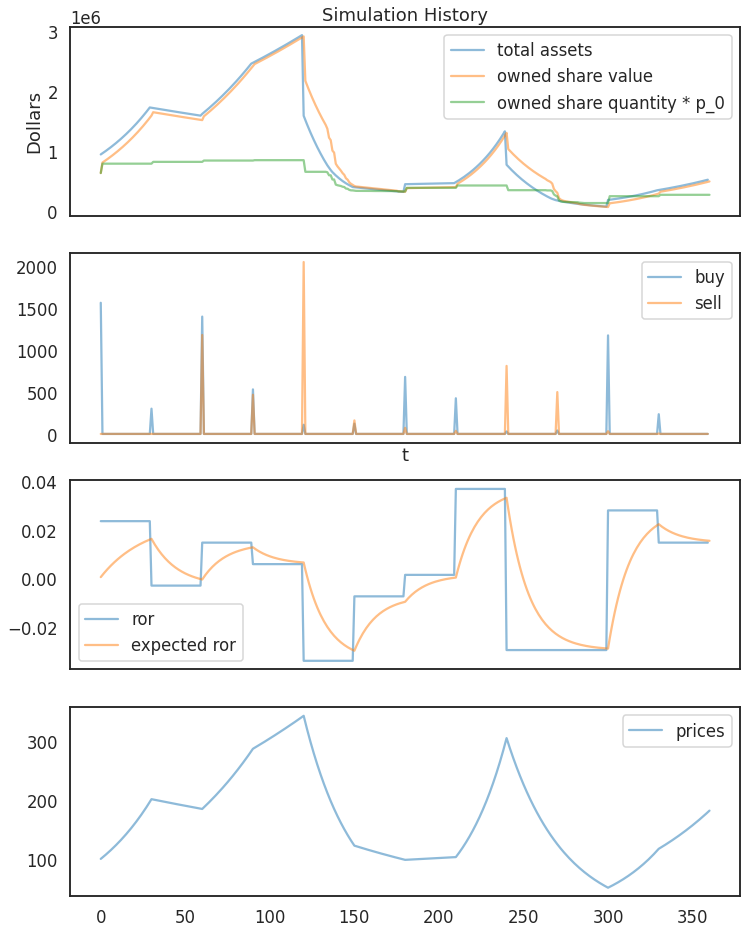

In [20]:
fig, ax = plt.subplots(
    4, 1,
    sharex='col',
    #sharey='col',
    figsize=(12,16),
)

ax[0].plot(total_asset_levels_list[1:], alpha=0.5, label='total assets')
ax[0].plot([p * o for (p,o) in zip(fm.prices, owned_shares_list)], alpha=0.5, label='owned share value')
ax[0].plot([100 * o for (p,o) in zip(fm.prices, owned_shares_list)], alpha=0.5, label='owned share quantity * p_0')
ax[0].legend()

ax[1].plot([bs[0] for bs in buy_sell_list], alpha=0.5, label='buy')
ax[1].plot([bs[1] for bs in buy_sell_list], alpha=0.5, label='sell')
ax[1].legend()

ax[2].plot(fm.ror_list, alpha=0.5, label='ror')
ax[2].plot(fm.expected_ror_list, alpha=0.5, label='expected ror')
ax[2].legend()

ax[3].plot(fm.prices, alpha=0.5, label='prices')
ax[3].legend()
    
ax[0].set_title("Simulation History")
ax[0].set_ylabel("Dollars")
ax[1].set_xlabel("t")
        
plt.show()

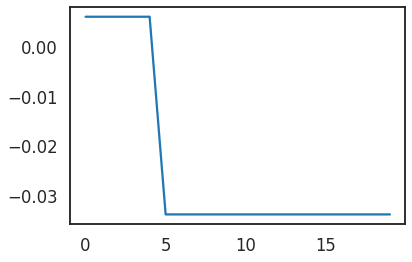

In [21]:
plt.plot(fm.ror_list[115:135])

In [22]:
data = pd.DataFrame.from_dict({
    't' : range(len(fm.prices)),
    'prices' : fm.prices,
    'buy' : [None] + [bs[0] for bs in buy_sell_list],
    'sell' : [None]  + [bs[1] for bs in buy_sell_list],
    'owned' : owned_shares_list,
    'total_assets' : total_asset_levels_list,
    'ror' : [None] + fm.ror_list,
    'expected_ror' : fm.expected_ror_list,
    #'expected_ror_q' : [ror_quarterly(er, days_per_quarter) for er in expected_ror_list],
    'expected_std' : fm.expected_std_list,
    #'expected_std_q' : [sig_quarterly(es, days_per_quarter) for es in expected_std_list],
})


data

,t,prices,buy,sell,owned,total_assets,ror,expected_ror,expected_std
0,0,100.000000,NaN,NaN,6359.379704,6.359380e+05,NaN,0.000628,0.011988
1,1,102.358370,1564.0,0.0,7924.291390,9.462838e+05,0.023584,0.001492,0.012517
2,2,104.772359,0.0,0.0,7924.291390,9.654129e+05,0.023584,0.002324,0.012903
3,3,107.243278,0.0,0.0,7924.291390,9.849932e+05,0.023584,0.003124,0.013176
4,4,109.772471,0.0,0.0,7924.291390,1.005035e+06,0.023584,0.003895,0.013358
...,...,...,...,...,...,...,...,...,...
356,356,171.464097,0.0,0.0,2729.220607,4.964257e+05,0.014769,0.015796,0.006822
357,357,173.996449,0.0,0.0,2729.220607,5.033370e+05,0.014769,0.015720,0.006570
358,358,176.566202,0.0,0.0,2729.220607,5.103504e+05,0.014769,0.015650,0.006328
359,359,179.173906,0.0,0.0,2729.220607,5.174674e+05,0.014769,0.015585,0.006094


In [23]:
data.corr()

,t,prices,buy,sell,owned,total_assets,ror,expected_ror,expected_std
t,1.000000,-0.427496,-0.069194,-0.041160,-0.891204,-0.700986,-0.044897,-0.062781,0.368359
prices,-0.427496,1.000000,-0.055218,0.131199,0.677481,0.833557,-0.006424,0.411667,-0.196894
buy,-0.069194,-0.055218,1.000000,0.326285,0.059999,0.009366,0.084590,-0.028329,-0.037956
sell,-0.041160,0.131199,0.326285,1.000000,0.045444,0.054718,-0.087479,0.018978,-0.018892
owned,-0.891204,0.677481,0.059999,0.045444,1.000000,0.910106,0.221716,0.348575,-0.391493
total_assets,-0.700986,0.833557,0.009366,0.054718,0.910106,1.000000,0.224220,0.409023,-0.475759
ror,-0.044897,-0.006424,0.084590,-0.087479,0.221716,0.224220,1.000000,0.769319,-0.155590
expected_ror,-0.062781,0.411667,-0.028329,0.018978,0.348575,0.409023,0.769319,1.000000,-0.093720
expected_std,0.368359,-0.196894,-0.037956,-0.018892,-0.391493,-0.475759,-0.155590,-0.093720,1.000000


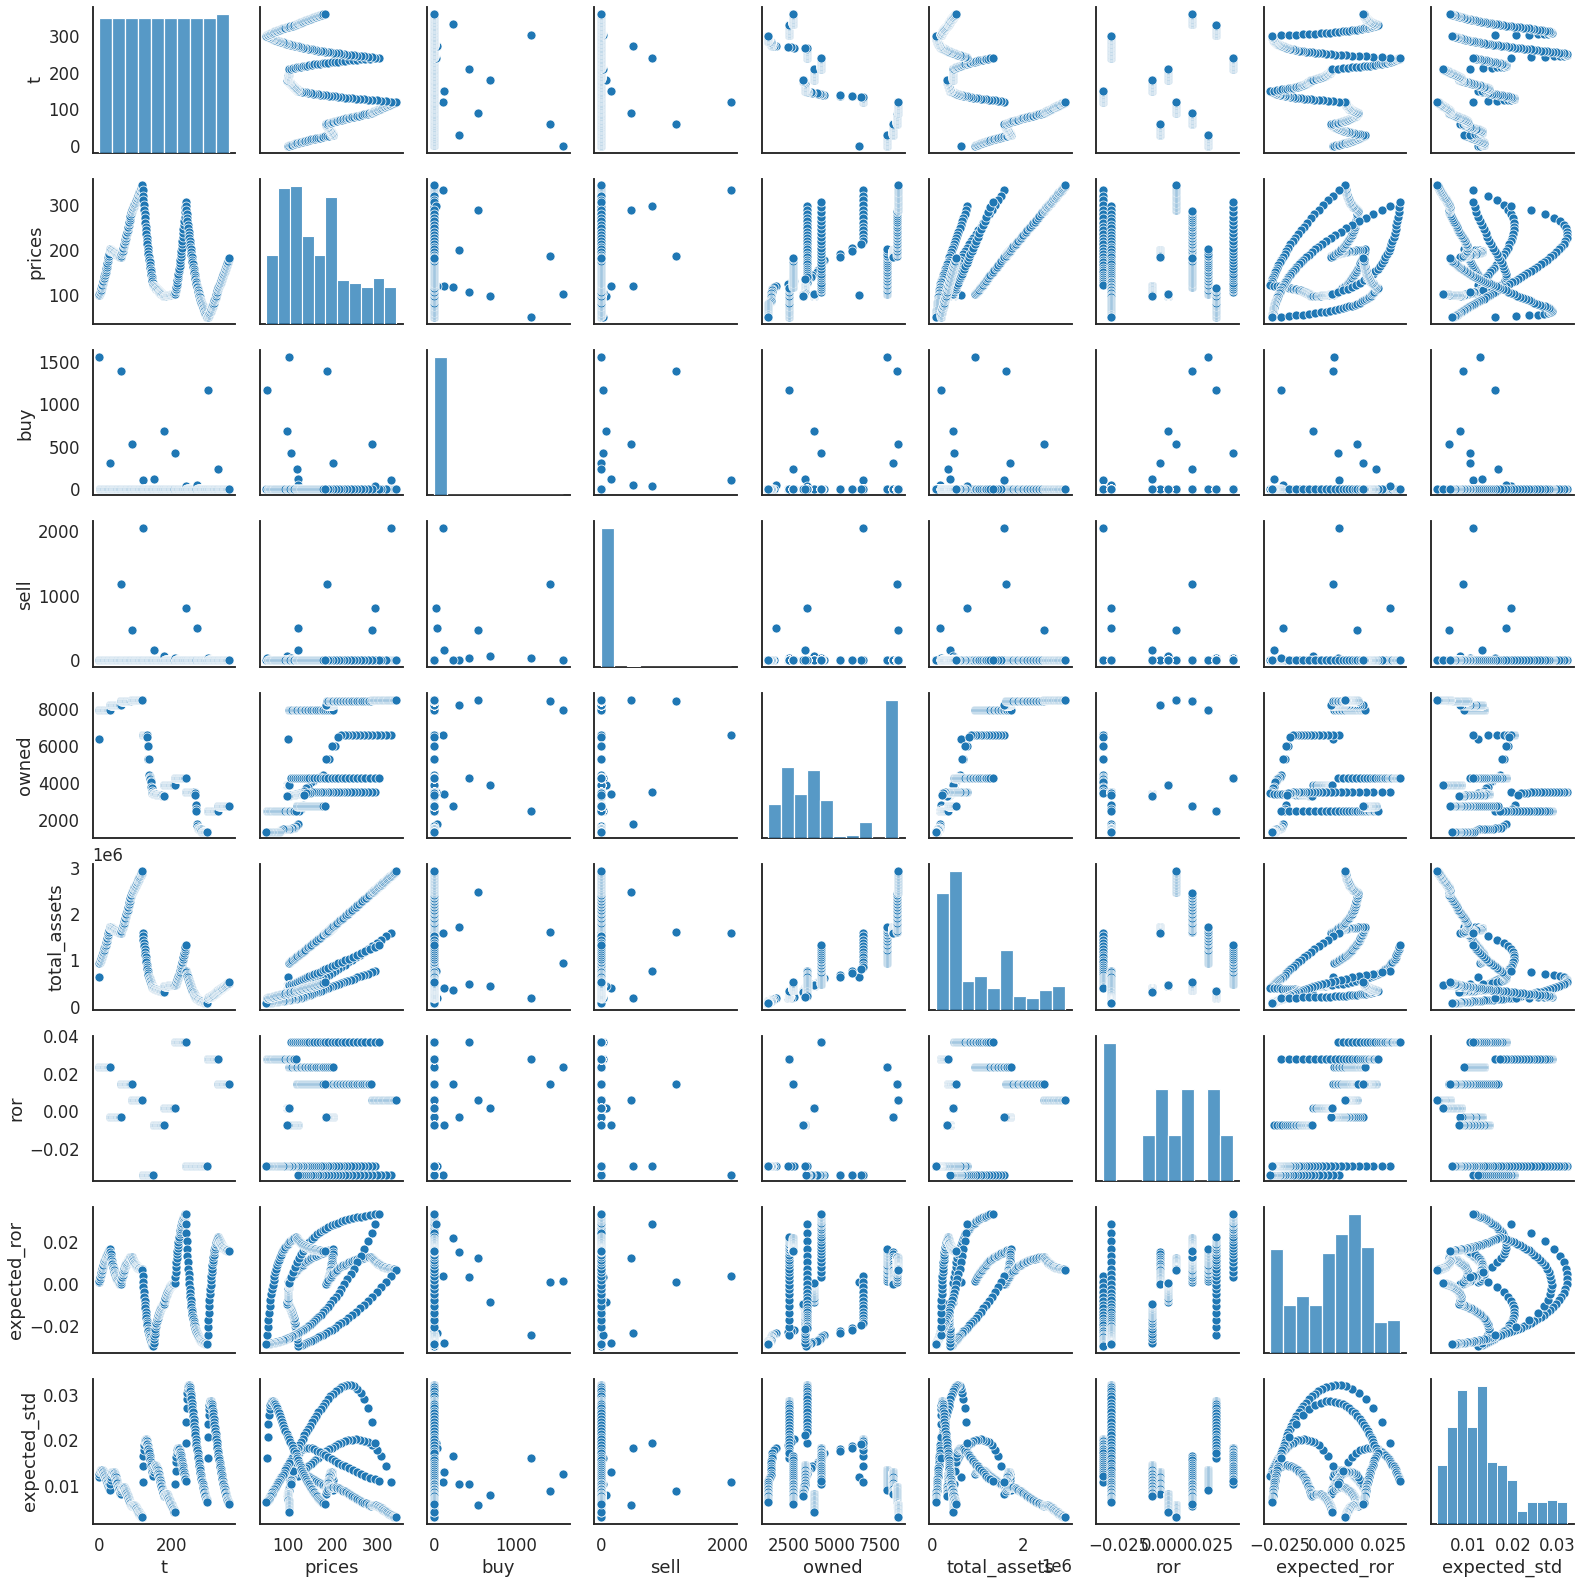

In [24]:
import seaborn as sns

sns.pairplot(data)